# **Course Project Chapter 2**
_David da Paz (March 2018)_
___
1. Importing and cleaning the data
     - 1.1 Dealing with missing values
     - 1.2 Dispersion of the products content
     - 1.3 Filling missing values
     - 1.4 Removing duplicates
     - 1.5 Countries
2. Manipulating the data
     - 2.1 What are the foods that have the highest ratios of each macronutrient?
     - 2.2 What are the foods that are most balanced? 
     - 2.3 What is the macronutrient breakdown across different countries?
3. Text data
     - 3.1 What are the most common ingredients?
4. Time-series analysis
     - 4.1 Mean time difference between 'created_datetime' and 'last_modified_datetime'
     - 4.2 Mean number of created items per month over the timeline of the data
     - 4.3 Visualizations
5. Build a database
     - 5.1 Restrict the data
     - 5.2 Create a connection
     - 5.3 Create tables
     - 5.4 Fill the database
     - 5.5 Run a query
6. Finding correlations
    - 6.1 Relationship between the nutritional score and the other variables

___
## 1. Importing and cleaning the data

Loading the packages to be used in the workbook:

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
%matplotlib inline

and loading the dataset:

In [2]:
food_df = pd.read_csv('en.openfoodfacts.org.products.tsv', low_memory=False, sep='\t')
food_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Columns: 163 entries, code to water-hardness_100g
dtypes: float64(107), object(56)
memory usage: 442.8+ MB


### 1.1 Dealing with missing values

Our original dataset has 356'027 rows and 163 columns.

In [3]:
food_df.shape

(356027, 163)

Since we are interested in knowing product names, we will remove all rows with missig product names. We will also remove all product names which are numbers.

In [4]:
food_df['product_name'].isnull().sum()

17512

In [5]:
food_df.dropna(subset = ['product_name'], inplace=True)

In [6]:
food_df['product_name'].isnull().sum()

0

In [7]:
food_df.shape

(338515, 163)

In [8]:
food_df.sort_values('product_name',ascending=False)['product_name']

347175                                  Ｌｏｎｋａ牌花生杂果味软牛轧糖180克
350881                                            푹신푹신 말랑카우
294328                             폰즈소스 - Shabu Shabu Ponzu
121569                                                   통깨
294092                                               타코야끼가루
351007                                               크린프레이크
350749                                                  콩두유
350869                                                칠성사이다
350771                                  친한 참기름 (sesame oil)
350849                                                 초고추장
294327                                                 참깨소스
27110                                                    짜왕
350853                                                  진간장
350850                                                재래식된장
350840                                              자연한입 망고
350951                         자연은 튼튼 (Jayeon-eun Teunteun)
350959                                  

In [9]:
numeric_products = food_df[food_df.product_name.apply(lambda x: x.isnumeric())]['product_name']
numeric_products

112926              180
112931              180
112936              180
125313             1664
163978     854615002375
177004      15666666666
189193          2722506
198009             1664
198013             1664
198016             1664
198092             1664
223528             1637
226857          2230262
254143             1848
268193    3660005523248
275164              109
277249             2012
311093               24
312675                1
333902             1881
339930             1881
349301               86
Name: product_name, dtype: object

In [10]:
food_df.drop(numeric_products.index[:],inplace=True)

In [11]:
food_df[food_df.product_name.apply(lambda x: x.isnumeric())]['product_name']

Series([], Name: product_name, dtype: object)

In [12]:
food_df.shape

(338493, 163)

At this stage, the dataframe contains $\sim$338'000 products which are described according to 163 variables. Looking at these variables, we can see that some of them do not contain any product. We do this by applying a function that first created a dataset with the sum of all the missing values. We name the columns accordingly and the filling factor, meaning how many rows for a given column are filled with non NaN entries. As we see in the table below, for all these columns the filling factor is zero. In other words, we can delete the columns without losing any relevant information to the dataset.

In [13]:
def filling_factor(food_df):
    missing_df = food_df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df['filling_factor'] = (food_df.shape[0]-missing_df['missing_count'])/food_df.shape[0]*100
    missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
    return missing_df
#____________________________________
missing_df = filling_factor(food_df)
missing_df[missing_df['filling_factor'] == 0]

,column_name,missing_count,filling_factor
0,water-hardness_100g,338493,0.0
1,ingredients_from_palm_oil,338493,0.0
2,ingredients_that_may_be_from_palm_oil,338493,0.0
3,nutrition_grade_uk,338493,0.0
4,-nervonic-acid_100g,338493,0.0
5,-erucic-acid_100g,338493,0.0
6,-mead-acid_100g,338493,0.0
7,-elaidic-acid_100g,338493,0.0
8,-butyric-acid_100g,338493,0.0
9,-caproic-acid_100g,338493,0.0


Let's drop these 16 columns since they contain no information at all.

In [14]:
food_df.dropna(axis = 1, how = 'all',inplace=True)
food_df.shape

(338493, 147)

In the following, let's focus on products that contain some information on its nutrients. This information is contained in the variables with the **\_100g** suffix. Hence, we are keeping the products where at least one of these columns contains some information:

In [15]:
#_______________________
# looking at empty rows
composant = []
for s in food_df.columns:
    if '_100g' in s: composant.append(s)
df_subset_columns = food_df[composant]
print('empty _100g rows: {}'.format(df_subset_columns.isnull().all(axis=1).sum()))
#___________________
# and deleting them
food_df = food_df[df_subset_columns.notnull().any(axis=1)]

empty _100g rows: 41893


Now that we have deleted some irrelevant columns and rows, let's see if we can further clean the dataset. For this, we will use the filling_factor function to our new dataset "df_new". It's easy to see it visually through a horizontal bar chart. We will also add a limit to split what we will take into our analysis with a vertical bar chart since i think it's a better visualisation than the horizontal bar chart.

In [16]:
col_filling = filling_factor(food_df)

The horizontal bar chart:

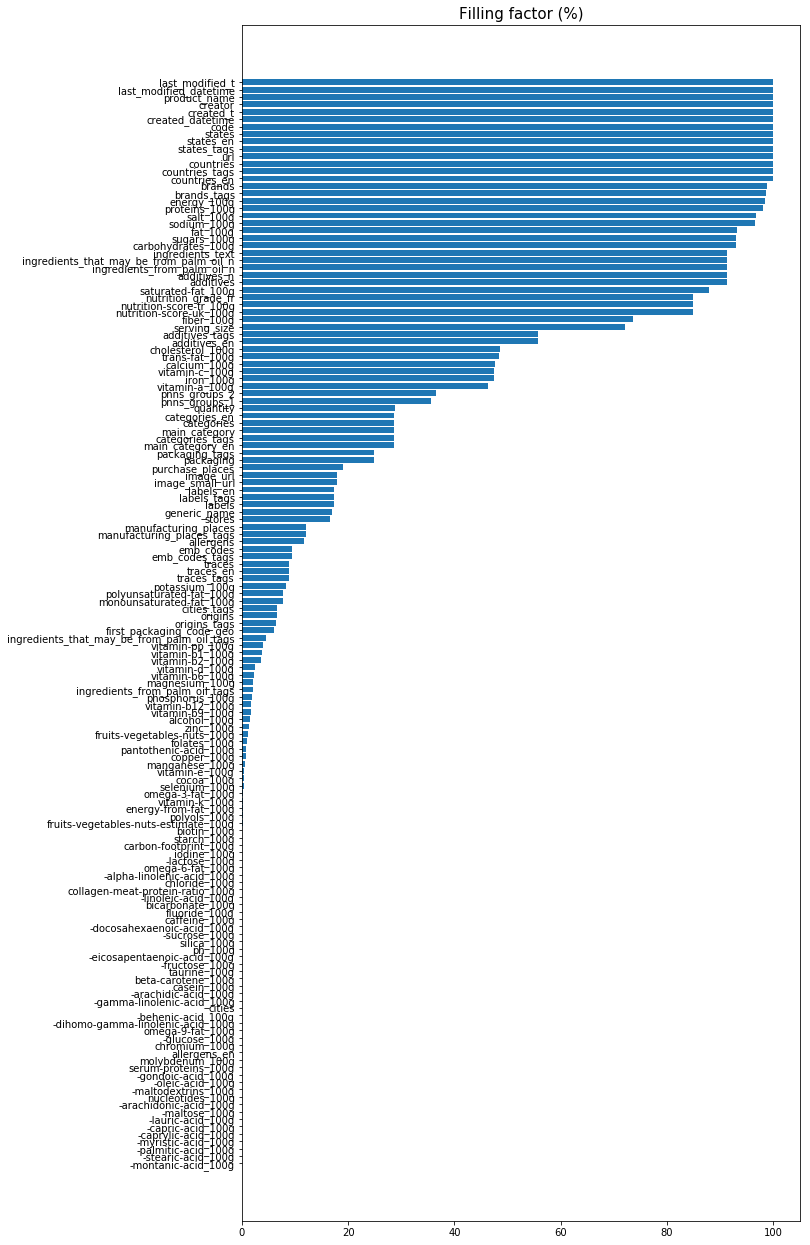

In [17]:
y_axis  = list(col_filling['filling_factor'])
x_axis  = [i for i in range(len(col_filling))]
x_label = list(col_filling['column_name'])
fig = plt.figure(figsize=(10, 22))
plt.yticks(x_axis, x_label)
plt.title('Filling factor (%)', fontsize = 15)
plt.barh(x_axis, y_axis)
plt.show()

The vertical bar chart and our threshold which is at 20%. In other words, if the column feature is not filled with at least 20% then if will be deleted.

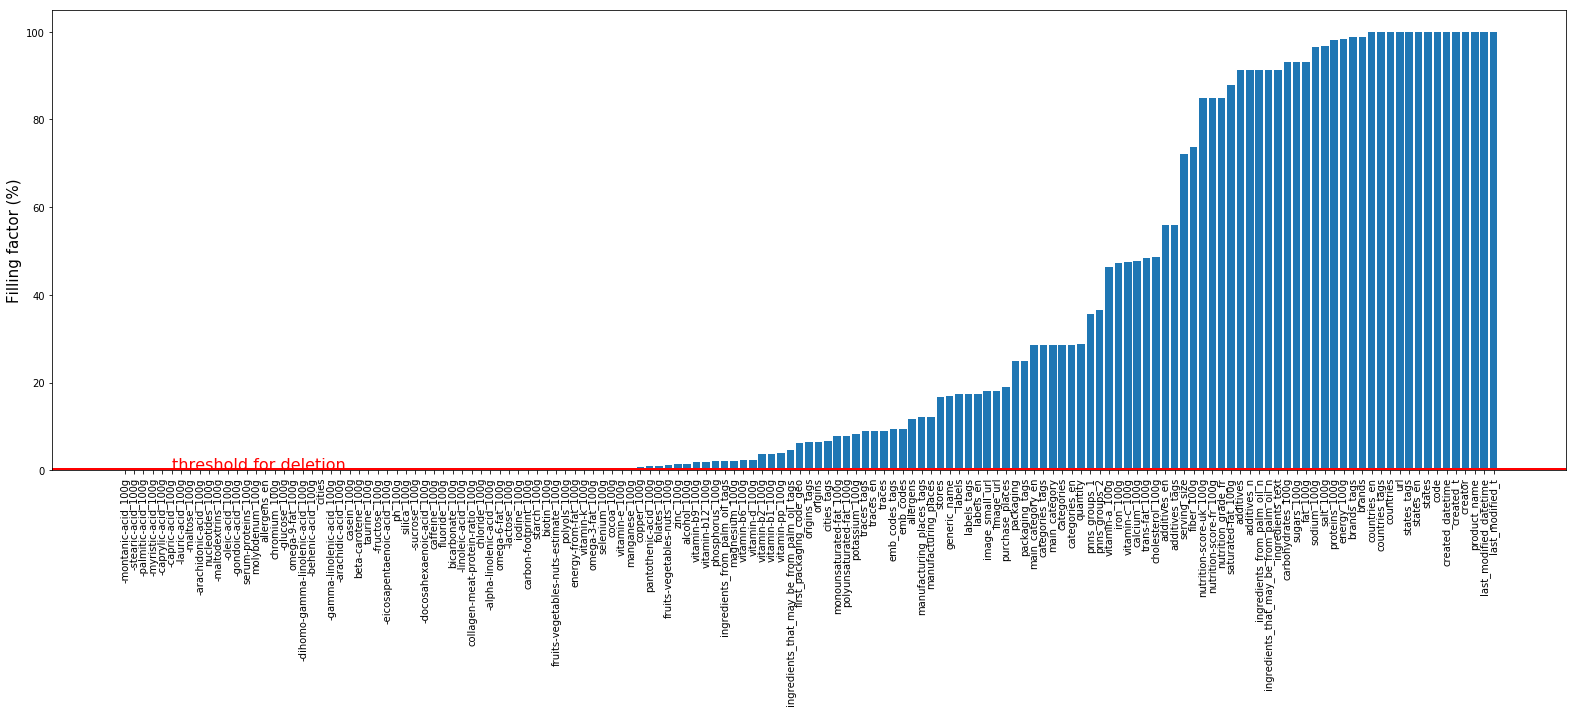

In [18]:
y_axis  = list(col_filling['filling_factor'])
x_axis  = [i for i in range(len(col_filling))]
x_label = list(col_filling['column_name'])
fig = plt.figure(figsize=(22, 10))
plt.xticks(rotation=90)
plt.xticks(x_axis, x_label)
plt.ylabel('Filling factor (%)', fontsize = 15)
plt.bar(x_axis, y_axis)
plt.axhline(y=0.2, linewidth=2, color = 'r')
plt.text(5, 0.21, 'threshold for deletion', fontsize = 16, color = 'r')
plt.tight_layout()
plt.show()

Since the previous chart contains all the columns, let's zoom in using another chart. It's the same data as the previous, only we are showing columns with a lower than 90% filling factor. The aim is then to delete all the columns below the treshold line. 

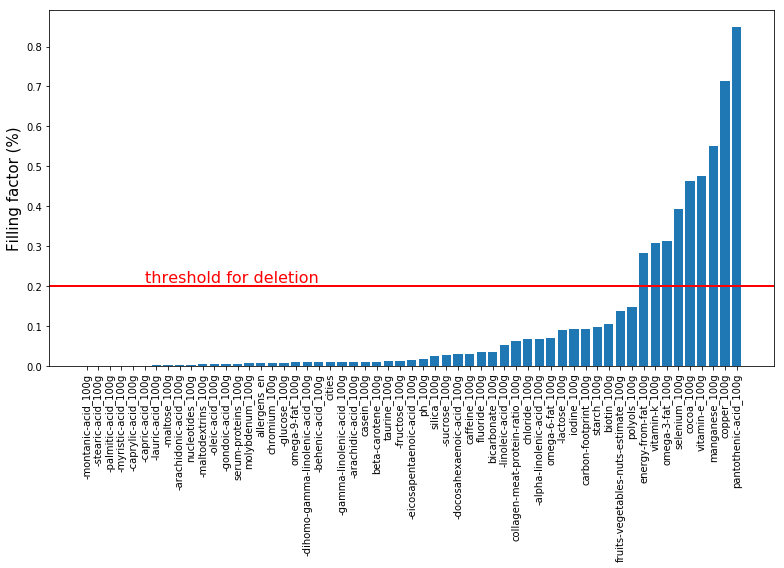

In [19]:
col_filling_2 = col_filling.loc[col_filling['filling_factor'] < 0.9]
y_axis  = list(col_filling_2['filling_factor'])
x_axis  = [i for i in range(len(col_filling_2))]
x_label = list(col_filling_2['column_name'])
fig = plt.figure(figsize=(11, 8))
plt.xticks(rotation=90)
plt.xticks(x_axis, x_label)
plt.ylabel('Filling factor (%)', fontsize = 15)
plt.bar(x_axis, y_axis)
plt.axhline(y=0.2, linewidth=2, color = 'r')
plt.text(5, 0.21, 'threshold for deletion', fontsize = 16, color = 'r')
plt.tight_layout()
plt.show()

From these graphs, we can see that many variables do not contain a significant number of products. I then decide to drop the columns that contain less than 70 products:

In [20]:
columns_to_remove = list(col_filling[food_df.shape[0] - 
                                     col_filling['missing_count'] < 80]['column_name'])
columns_to_remove

['-montanic-acid_100g',
 '-stearic-acid_100g',
 '-palmitic-acid_100g',
 '-myristic-acid_100g',
 '-caprylic-acid_100g',
 '-capric-acid_100g',
 '-lauric-acid_100g',
 '-maltose_100g',
 '-arachidonic-acid_100g',
 'nucleotides_100g',
 '-maltodextrins_100g',
 '-oleic-acid_100g',
 '-gondoic-acid_100g',
 'serum-proteins_100g',
 'molybdenum_100g',
 'allergens_en',
 'chromium_100g',
 '-glucose_100g',
 'omega-9-fat_100g',
 '-dihomo-gamma-linolenic-acid_100g',
 '-behenic-acid_100g',
 'cities',
 '-gamma-linolenic-acid_100g',
 '-arachidic-acid_100g',
 'casein_100g',
 'beta-carotene_100g',
 'taurine_100g',
 '-fructose_100g',
 '-eicosapentaenoic-acid_100g',
 'ph_100g',
 'silica_100g',
 '-sucrose_100g']

In [21]:
len(columns_to_remove)

32

We will remove 31 columns.

In [22]:
food_df.drop(columns_to_remove, axis = 1, inplace = True)

Looking at our missing values and shape.

In [23]:
food_df.isnull().sum()

code                                        26
url                                         26
creator                                      1
created_t                                    3
created_datetime                            10
last_modified_t                              0
last_modified_datetime                       0
product_name                                 0
generic_name                            246208
quantity                                211162
packaging                               222984
packaging_tags                          222984
brands                                    3765
brands_tags                               3774
categories                              211680
categories_tags                         211704
categories_en                           211678
origins                                 277234
origins_tags                            277255
manufacturing_places                    260740
manufacturing_places_tags               260743
labels       

In [24]:
food_df.shape

(296600, 115)

### 1.2 Dispersion of the products content

After some research, it seems there are certain product contents that refer to the same. In other words, biotin is also known as vitamin b7. Idem for the other two.

In [25]:
food_df.rename(columns={'biotin_100g':'vitamin-b7_100g'}, inplace=True)
food_df.rename(columns={'pantothenic-acid_100g':'vitamin-b5_100g'}, inplace=True)
food_df.rename(columns={'vitamin-pp_100g':'vitamin-b3_100g'}, inplace=True)

In [26]:
food_df.shape

(296600, 115)

### 1.3 Filling missing values

I will fill for columns representing measures NaN by zero. And for columns representing a description I will replace NaN by the string 'not available'. The column 'energy_100g' is the one that delimits the measuring features from the descriptive.

In [27]:
food_df.dtypes[50:65]

states                         object
states_tags                    object
states_en                      object
main_category                  object
main_category_en               object
image_url                      object
image_small_url                object
energy_100g                   float64
energy-from-fat_100g          float64
fat_100g                      float64
saturated-fat_100g            float64
monounsaturated-fat_100g      float64
polyunsaturated-fat_100g      float64
omega-3-fat_100g              float64
-alpha-linolenic-acid_100g    float64
dtype: object

In [28]:
for col in food_df.loc[:,'energy_100g':].columns:
    food_df[col].fillna(value = 0.0, inplace=True)

In [29]:
for col in food_df.loc[:,:'energy_100g'].columns:
    food_df[col].fillna(value = 'not available', inplace=True)

In [30]:
food_df.isnull().sum()

code                                    0
url                                     0
creator                                 0
created_t                               0
created_datetime                        0
last_modified_t                         0
last_modified_datetime                  0
product_name                            0
generic_name                            0
quantity                                0
packaging                               0
packaging_tags                          0
brands                                  0
brands_tags                             0
categories                              0
categories_tags                         0
categories_en                           0
origins                                 0
origins_tags                            0
manufacturing_places                    0
manufacturing_places_tags               0
labels                                  0
labels_tags                             0
labels_en                         

In [31]:
food_df.isnull().sum().sum()

0

Mission accomplished - we have cleaned the dataframe from missing values.

### 1.4 Removing duplicates

In [32]:
food_df.loc[food_df.duplicated(),:]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,selenium_100g,iodine_100g,caffeine_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g


There are no duplicated rows in the dataset.

### 1.5 Features selection

There are so many columns which are not relevant for the questions to answer that i decided to select only the columns which i believe will help me to answer the questions.

In [33]:
food_df = food_df[['created_t','created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name',
                   'generic_name','categories_en','countries_en','ingredients_text','main_category_en',
                  'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g',
                   'monounsaturated-fat_100g',
                   'polyunsaturated-fat_100g', 'omega-3-fat_100g', '-alpha-linolenic-acid_100g',
                   '-docosahexaenoic-acid_100g',
                   'omega-6-fat_100g', '-linoleic-acid_100g', 'trans-fat_100g', 'cholesterol_100g',
                   'carbohydrates_100g', 'sugars_100g', '-lactose_100g', 'starch_100g', 'polyols_100g', 'fiber_100g',
                   'proteins_100g', 'salt_100g', 'sodium_100g',
                   'alcohol_100g', 'vitamin-a_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g',
                   'vitamin-c_100g', 'vitamin-b1_100g',
                   'vitamin-b2_100g', 'vitamin-b3_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g',
                   'vitamin-b12_100g', 'vitamin-b7_100g',
                   'vitamin-b5_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g',
                   'phosphorus_100g', 'iron_100g', 'magnesium_100g',
                   'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g', 'selenium_100g', 'iodine_100g',
                   'caffeine_100g', 'fruits-vegetables-nuts_100g','nutrition-score-uk_100g']]

___
## 2. Manipulating the data

### 2.1 What are the foods that have the highest ratios of each macronutrient?

There are three macronutrients: Carbohydrates, Proteins and Fats. Each of them can be identified in the dataset.

In [34]:
macronutrients = food_df[['product_name','countries_en','carbohydrates_100g','proteins_100g','fat_100g']]

Carbohydrates:

In [35]:
macronutrients.sort_values('carbohydrates_100g',ascending=False)[['product_name','carbohydrates_100g']].head(10)

,product_name,carbohydrates_100g
157495,"Tamarind Juice With Nata De Coco, Tamarind",2916.67
71673,"Toaster Pastries, Strawberry",209.38
281780,Kichererbsen,165.00
157297,Beurre d'érable,164.00
311656,CHOCOLAT ROBERT,147.00
352368,Banane sèche,139.00
112519,Tomato Ketchup,136.00
135091,Mango Jalapeno,125.00
74345,Icing Decorations,120.00
121180,Naturally Caffeinated Pure Empower Mint Dietar...,120.00


Proteins:

In [36]:
macronutrients.sort_values('proteins_100g',ascending=False)[['product_name','proteins_100g']].head(10)

,product_name,proteins_100g
347260,"Nusco, Chocolate Spread, Chocolate",430.0
259638,Spécialité au soja,305.0
90840,Garlic Powder,100.0
71739,Unflavored Gelatin,100.0
314823,Marshall - Major Noir,100.0
170561,Sprinkles,100.0
311887,Eau,100.0
41365,Unflavored Gelatin,100.0
41366,Gelatin,100.0
310541,Vodka Zubrowka 70cL,100.0


Fats:

In [37]:
macronutrients.sort_values('fat_100g',ascending=False)[['product_name','fat_100g']].head(10)

,product_name,fat_100g
336897,Graine de couscous moyen,105.0
334384,Ekstra Jomfru Olivenolie,101.0
310412,Kujawski 3 Ziarna,100.0
345089,Óleo alimentar,100.0
229312,Huile d'Olive vierge extra,100.0
4159,Pure Vegetable Oil,100.0
4158,Virgin Coconut Oil,100.0
4157,Coconut Oil,100.0
140163,"International Harvest's, Organic Coconut Oil",100.0
326219,Sais : Astra 10 : Graisse comestible avec 10% ...,100.0


### 2.2 What are the foods that are most balanced? 

A balanced food can be defined as having the highest level of proteins and lowest amount of carbs and fats. Thus, if we construct a new feature where whe calculate proteins - carbs - fats in all products for which the three macronutrients exists, then the highest values will be our balanced foods.

In [38]:
food_df['balanced_food'] = np.where((food_df['proteins_100g'] > 0) &
                                    (food_df['carbohydrates_100g'] > 0) &
                                   (food_df['fat_100g'] > 0),
                                    food_df['proteins_100g'] - food_df['carbohydrates_100g'] - food_df['fat_100g'],
                                   0)

In [39]:
food_df.sort_values('balanced_food',ascending=False)[['product_name','balanced_food']].head(10)

,product_name,balanced_food
259638,Spécialité au soja,284.90
310541,Vodka Zubrowka 70cL,98.00
251004,Pure Isolate,89.00
289043,Inko X-treme Muscle 95,88.31
300390,Impact whey isolate,87.20
301484,Pure Whey Isolate 90 Unflavoured,87.00
20759,100% Soja Protein Vanille,86.90
572,100% Soja Protein Neutral,86.90
306,100% Soja Protein Haselnuss,86.90
121339,Isolate ht,86.89


### 2.3 What is the macronutrient breakdown across different countries?

Let's check the mean carbohydrates for the most represented countries in the dataset:

In [40]:
food_country=food_df['countries_en'].value_counts(sort=True, dropna=False)
food_country.head(10)

United States         171617
France                 94543
Switzerland             8483
Germany                 5232
Spain                   3191
United Kingdom          1890
France,Switzerland      1396
Russia                  1010
Belgium                  733
Belgium,France           682
Name: countries_en, dtype: int64

In [41]:
food_US = food_df[food_df['countries_en'] == 'United States']
food_FR = food_df[food_df['countries_en'] == 'France']
food_CH = food_df[food_df['countries_en'] == 'Switzerland']
food_DE = food_df[food_df['countries_en'] == 'Germany']
food_ES = food_df[food_df['countries_en'] == 'Spain']
food_UK = food_df[food_df['countries_en'] == 'United Kingdom']

In [42]:
food_US['carbohydrates_100g'].mean()

33.674203278228546

In [43]:
food_FR['carbohydrates_100g'].mean()

22.012111841173084

In [44]:
food_CH['carbohydrates_100g'].mean()

28.949798066721694

In [45]:
food_ES['carbohydrates_100g'].mean()

25.916656220620467

In [46]:
food_UK['carbohydrates_100g'].mean()

22.32205291005289

___
## 3. Text data

### 3.1 What are the most common ingredients?

In [ ]:
# we need to send it to a list and see the most common element in the list using a word counter

In [47]:
ing_df = food_df['ingredients_text']

In [48]:
ing_df = ing_df.str.lower()
#ing_df[0]

In [49]:
ing_df.iloc[2]

'organic hazelnuts, organic cashews, organic walnuts almonds, organic sunflower oil, sea salt.'

In [50]:
list_ingredients = ing_df.tolist()
list_ingredients

['bananas, vegetable oil (coconut oil, corn oil and/or palm oil) sugar, natural banana flavor.',
 'peanuts, wheat flour, sugar, rice flour, tapioca starch, salt, leavening (ammonium bicarbonate, baking soda), soy sauce (water, soybeans, wheat, salt), potato starch.',
 'organic hazelnuts, organic cashews, organic walnuts almonds, organic sunflower oil, sea salt.',
 'organic polenta',
 'rolled oats, grape concentrate, expeller pressed canola oil, sunflower seeds, almonds, walnuts oat bran, sesame seeds, cashews, natural vitamin e.',
 'organic long grain white rice',
 'org oats, org hemp granola (org oats, evaporated cane juice, org expeller-pressed canola oil, crispy rice [org brown rice flour, org evaporated cane juice, org molasses, sea salt], org flax seeds, org oat solids, hemp seeds), org raisins, org dates, org almonds, org hazelnuts, org coconut, org sunflower seeds, org pumpkin seeds, org flax seeds, org corn flakes (org corn meal, org grape and/or pear juice concentrate, sea sal

In [51]:
list_ingredients[0].split(',')

['bananas',
 ' vegetable oil (coconut oil',
 ' corn oil and/or palm oil) sugar',
 ' natural banana flavor.']

In [52]:
my_list = [item.split(',') for item in list_ingredients]

[['bananas',
  ' vegetable oil (coconut oil',
  ' corn oil and/or palm oil) sugar',
  ' natural banana flavor.'],
 ['peanuts',
  ' wheat flour',
  ' sugar',
  ' rice flour',
  ' tapioca starch',
  ' salt',
  ' leavening (ammonium bicarbonate',
  ' baking soda)',
  ' soy sauce (water',
  ' soybeans',
  ' wheat',
  ' salt)',
  ' potato starch.'],
 ['organic hazelnuts',
  ' organic cashews',
  ' organic walnuts almonds',
  ' organic sunflower oil',
  ' sea salt.'],
 ['organic polenta'],
 ['rolled oats',
  ' grape concentrate',
  ' expeller pressed canola oil',
  ' sunflower seeds',
  ' almonds',
  ' walnuts oat bran',
  ' sesame seeds',
  ' cashews',
  ' natural vitamin e.'],
 ['organic long grain white rice'],
 ['org oats',
  ' org hemp granola (org oats',
  ' evaporated cane juice',
  ' org expeller-pressed canola oil',
  ' crispy rice [org brown rice flour',
  ' org evaporated cane juice',
  ' org molasses',
  ' sea salt]',
  ' org flax seeds',
  ' org oat solids',
  ' hemp seeds)',
  

In [53]:
flat_list = [y for x in my_list for y in x]

['bananas',
 ' vegetable oil (coconut oil',
 ' corn oil and/or palm oil) sugar',
 ' natural banana flavor.',
 'peanuts',
 ' wheat flour',
 ' sugar',
 ' rice flour',
 ' tapioca starch',
 ' salt',
 ' leavening (ammonium bicarbonate',
 ' baking soda)',
 ' soy sauce (water',
 ' soybeans',
 ' wheat',
 ' salt)',
 ' potato starch.',
 'organic hazelnuts',
 ' organic cashews',
 ' organic walnuts almonds',
 ' organic sunflower oil',
 ' sea salt.',
 'organic polenta',
 'rolled oats',
 ' grape concentrate',
 ' expeller pressed canola oil',
 ' sunflower seeds',
 ' almonds',
 ' walnuts oat bran',
 ' sesame seeds',
 ' cashews',
 ' natural vitamin e.',
 'organic long grain white rice',
 'org oats',
 ' org hemp granola (org oats',
 ' evaporated cane juice',
 ' org expeller-pressed canola oil',
 ' crispy rice [org brown rice flour',
 ' org evaporated cane juice',
 ' org molasses',
 ' sea salt]',
 ' org flax seeds',
 ' org oat solids',
 ' hemp seeds)',
 ' org raisins',
 ' org dates',
 ' org almonds',
 ' 

In [56]:
df = pd.DataFrame(flat_list,columns=['ingredients'])
df

,ingredients
0,bananas
1,vegetable oil (coconut oil
2,corn oil and/or palm oil) sugar
3,natural banana flavor.
4,peanuts
5,wheat flour
6,sugar
7,rice flour
8,tapioca starch
9,salt


In [57]:
df['ingredients'].value_counts(sort=True, dropna=False)

 salt                                                                                                                                                                             83527
 sugar                                                                                                                                                                            53031
 water                                                                                                                                                                            48830
 sel                                                                                                                                                                              37655
not available                                                                                                                                                                     25919
 sucre                                                                          

___
## 4. Time series analysis

### 4.1 Mean time difference between 'created_datetime' and 'last_modified_datetime'

In [81]:
time = food_df[['created_datetime','last_modified_datetime']]

In [99]:
df = time['created_datetime'].apply(str).apply(lambda x: x[:x.find("T")])
time['modified_date'] = time['last_modified_datetime'].apply(str).apply(lambda x: x[:x.find("T")])

In [102]:
test = pd.to_datetime(df,errors='coerce')

In [103]:
test

1        2017-03-09
2        2017-03-09
3        2017-03-09
4        2017-03-09
5        2017-03-09
6        2017-03-09
7        2017-03-09
8        2017-03-09
9        2017-03-09
10       2017-03-09
11       2017-03-09
12       2017-03-09
13       2017-03-09
14       2017-03-09
15       2017-03-09
16       2017-03-09
17       2017-03-09
18       2017-03-09
19       2017-03-09
20       2017-03-09
21       2017-03-09
22       2017-03-09
23       2017-03-09
24       2017-03-10
25       2017-03-09
26       2017-03-09
27       2017-03-09
28       2017-03-09
29       2017-03-09
30       2017-03-09
            ...    
355930   2017-08-16
355940   2016-11-11
355955   2017-03-09
355957   2017-03-09
355960   2017-01-23
355965   2017-09-02
355966   2017-07-16
355967   2017-09-02
355968   2017-03-09
355970   2017-07-11
355971   2017-06-04
355972   2017-05-28
355973   2017-03-08
355974   2017-09-14
355975   2017-04-06
355977   2017-09-01
355978   2017-09-15
355979   2017-08-26
355980   2017-07-09


In [98]:
time['created_date']

1         2017-03-09
2         2017-03-09
3         2017-03-09
4         2017-03-09
5         2017-03-09
6         2017-03-09
7         2017-03-09
8         2017-03-09
9         2017-03-09
10        2017-03-09
11        2017-03-09
12        2017-03-09
13        2017-03-09
14        2017-03-09
15        2017-03-09
16        2017-03-09
17        2017-03-09
18        2017-03-09
19        2017-03-09
20        2017-03-09
21        2017-03-09
22        2017-03-09
23        2017-03-09
24        2017-03-10
25        2017-03-09
26        2017-03-09
27        2017-03-09
28        2017-03-09
29        2017-03-09
30        2017-03-09
             ...    
355930    2017-08-16
355940    2016-11-11
355955    2017-03-09
355957    2017-03-09
355960    2017-01-23
355965    2017-09-02
355966    2017-07-16
355967    2017-09-02
355968    2017-03-09
355970    2017-07-11
355971    2017-06-04
355972    2017-05-28
355973    2017-03-08
355974    2017-09-14
355975    2017-04-06
355977    2017-09-01
355978    201

In [ ]:
test.dtypes

In [88]:
test.tail(5)

,created_datetime,last_modified_datetime
356010,2017-04-01T20:52:18Z,2017-04-01T20:52:19Z
356015,2013-07-10T18:20:08Z,2016-01-03T20:00:15Z
356017,2013-04-28T15:30:39Z,2013-06-20T01:09:16Z
356022,2017-03-09T11:31:16Z,2017-04-03T18:34:59Z
356026,2017-03-09T15:18:29Z,2017-04-03T18:34:59Z


In [92]:
from dateutil.parser import parse

In [93]:
parse('2017-04-01T20:52:18Z')

datetime.datetime(2017, 4, 1, 20, 52, 18, tzinfo=tzutc())

### 4.2 Mean number of created items per month over the timeline of the data

### 4.3 Visualizations

# 5. Build a database

### 5.1 Restrict the data

### 5.2 Create a connection

In [87]:
db = sqlite3.connect("my_database.db")

### 5.3 Create tables

### 5.4 Fill the database

### 5.5 Run a query

 ___
## 6. Finding correlations

### 6.1 Relationship between the nutritional score and the other variables

In [ ]:
corrmat = food_df.corr()

sns.set(context="paper", font_scale = 1.2)
f, ax = plt.subplots(figsize=(11, 11))
cols = corrmat.nlargest(25, 'nutrition-score-uk_100g')['nutrition-score-uk_100g'].index
cm = corrmat.loc[cols, cols] 
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation with nutrition score", ha='center', fontsize = 18)
plt.show()

In [ ]:
test = macronutrients[macronutrients.product_name.apply(lambda x: x.isnumeric())]

In [ ]:
test

In [ ]:
test.index.values

In [ ]:
test.index[:]

In [ ]:
macronutrients.drop(test.index[:],inplace=True)

In [ ]:
macronutrients[macronutrients.product_name.apply(lambda x: x.isnumeric())]